In [1]:

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from core.finall_forecast import Forecaster
from dateutil.relativedelta import relativedelta
import datetime
from tqdm.auto import tqdm

import pyodbc
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import warnings; warnings.simplefilter('ignore')

from multiprocessing.pool import ThreadPool

In [2]:
class Data_Preprocess:
    def __init__(self, conn_str:tuple):
        self.cnxn = pyodbc.connect(conn_str)
        
    def generate_data(self):
        sql_query = """
            SELECT 
            Project_ID,
            Project_Name,
            Period,
            Y,
            M,
            Bill_1, 
            TO_1
            
            FROM _AG_Bad_Or_Good_New 
            where
            Y >= 2021"""
        df = self.downloading_data(sql_query)
        df_new = df[['Project_ID', 'Project_Name', 'Period', 'TO_1', 'Y', 'M', 'Bill_1']].groupby(['Project_ID','Project_Name', 'Period', 'Y', 'M']).sum().reset_index()
        
    
        return df_new
    
    def downloading_data(self, sql_query:str)->pd.DataFrame:

        df = pd.read_sql(sql_query, self.cnxn)
        self.cnxn.close()

        return df

In [3]:
conn_str = (
    r'DRIVER={ODBC Driver 17 for SQL Server};'
    r'SERVER=sql2014;'
    r'DATABASE=devMARS;'
    r'Trusted_Connection=yes;'
)

In [4]:
df = Data_Preprocess(conn_str=conn_str).generate_data()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Project_ID    291 non-null    object 
 1   Project_Name  291 non-null    object 
 2   Period        291 non-null    object 
 3   Y             291 non-null    int64  
 4   M             291 non-null    int64  
 5   TO_1          291 non-null    float64
 6   Bill_1        291 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 16.0+ KB


In [6]:
df = df.loc[(df['Y'] != 2025)]

In [7]:
def run_model(name_:str):
    forecast_2025 = Forecaster(
        data=df.loc[df['Project_Name']==name_].sort_values('Period')['TO_1'].to_numpy(), 
        data_index=df.loc[df['Project_Name']==name_][['TO_1', 'Period']].groupby('Period').sum().index.astype('datetime64[ns]'),
        project_id=df.loc[df['Project_Name']==name_]['Project_ID'].iloc[-1],
        project_name=name_,
        n_trials=20)
    pred = forecast_2025.predict(12)
    
    return pred

In [8]:
for i in zip(list(df['Project_Name'].unique())):
    print(i)

('Петербург Лето ТЦ / Petersburg Leto RC',)
('Уфа ТЦ / Ufa RC',)
('Пермь ТЦ / Perm RC',)
('Красноярск ТЦ / Krasnoyarsk RC',)
('Новокузнецк ТЦ/ Novokuznetsk RC',)
('Новосибирск Аура ТЦ / Novosibirsk Aura RC',)


In [9]:
df_arr = []

for indx_ in tqdm(['Красноярск ТЦ / Krasnoyarsk RC', 'Пермь ТЦ / Perm RC','Новокузнецк ТЦ/ Novokuznetsk RC',]):
    print(indx_)
    forecast_2025 = Forecaster(
        data=df.loc[df['Project_Name']==indx_].sort_values('Period')['TO_1'].to_numpy(), 
        data_index=df.loc[df['Project_Name']==indx_][['TO_1', 'Period']].groupby('Period').sum().index.astype('datetime64[ns]'),
        project_id=df.loc[df['Project_Name']==indx_]['Project_ID'].iloc[-1],
        project_name=indx_,
        n_trials=50)

    pred = forecast_2025.predict(12) 
    df_arr.append(pred)
    

  0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-03 12:39:52,899] A new study created in memory with name: no-name-de3d33fc-feed-43dc-8dc5-c722c4fee63f


Красноярск ТЦ / Krasnoyarsk RC


[I 2025-02-03 12:42:43,741] Trial 5 finished with value: 2.316200231949907e+17 and parameters: {'order': (np.int64(8), 1, np.int64(7)), 'seasonal_order': (np.int64(5), 1, np.int64(6), 12), 'trend': 'n'}. Best is trial 5 with value: 2.316200231949907e+17.
[I 2025-02-03 12:43:54,685] Trial 0 finished with value: 2.370412029141061e+17 and parameters: {'order': (np.int64(10), 1, np.int64(7)), 'seasonal_order': (np.int64(7), 1, np.int64(6), 12), 'trend': 'n'}. Best is trial 5 with value: 2.316200231949907e+17.
[I 2025-02-03 12:44:01,965] Trial 1 finished with value: 2.4695062831323302e+17 and parameters: {'order': (np.int64(8), 1, np.int64(10)), 'seasonal_order': (np.int64(8), 1, np.int64(6), 12), 'trend': 'n'}. Best is trial 5 with value: 2.316200231949907e+17.
[I 2025-02-03 12:44:35,720] Trial 3 finished with value: 3.065434057332413e+17 and parameters: {'order': (np.int64(7), 1, np.int64(6)), 'seasonal_order': (np.int64(10), 1, np.int64(7), 12), 'trend': None}. Best is trial 5 with value

20241201
Пермь ТЦ / Perm RC


[I 2025-02-03 13:12:49,595] Trial 1 finished with value: 2.4897515087681316e+16 and parameters: {'order': (np.int64(5), 1, np.int64(6)), 'seasonal_order': (np.int64(5), 1, np.int64(8), 12), 'trend': 'n'}. Best is trial 1 with value: 2.4897515087681316e+16.
[I 2025-02-03 13:13:32,897] Trial 6 finished with value: 2.7351712387868836e+16 and parameters: {'order': (np.int64(10), 1, np.int64(6)), 'seasonal_order': (np.int64(5), 1, np.int64(10), 12), 'trend': None}. Best is trial 1 with value: 2.4897515087681316e+16.
[I 2025-02-03 13:14:01,387] Trial 5 finished with value: inf and parameters: {'order': (np.int64(4), 1, np.int64(6)), 'seasonal_order': (np.int64(8), 1, np.int64(10), 12), 'trend': 'ct'}. Best is trial 1 with value: 2.4897515087681316e+16.
[I 2025-02-03 13:14:11,134] Trial 4 finished with value: 2.9092470826712292e+16 and parameters: {'order': (np.int64(4), 1, np.int64(8)), 'seasonal_order': (np.int64(5), 1, np.int64(10), 12), 'trend': None}. Best is trial 1 with value: 2.489751

20241201
Новокузнецк ТЦ/ Novokuznetsk RC


[I 2025-02-03 13:41:48,553] Trial 7 finished with value: 2.1040837926352988e+16 and parameters: {'order': (np.int64(5), 1, np.int64(9)), 'seasonal_order': (np.int64(7), 1, np.int64(9), 12), 'trend': 't'}. Best is trial 7 with value: 2.1040837926352988e+16.
[I 2025-02-03 13:41:53,016] Trial 4 finished with value: 2.0562580076992664e+16 and parameters: {'order': (np.int64(7), 1, np.int64(9)), 'seasonal_order': (np.int64(7), 1, np.int64(7), 12), 'trend': 'ct'}. Best is trial 4 with value: 2.0562580076992664e+16.
[I 2025-02-03 13:41:53,707] Trial 6 finished with value: 2.3622656380391204e+16 and parameters: {'order': (np.int64(4), 1, np.int64(7)), 'seasonal_order': (np.int64(7), 1, np.int64(9), 12), 'trend': 'ct'}. Best is trial 4 with value: 2.0562580076992664e+16.
[I 2025-02-03 13:42:07,630] Trial 3 finished with value: 2.232308658531011e+16 and parameters: {'order': (np.int64(8), 1, np.int64(8)), 'seasonal_order': (np.int64(8), 1, np.int64(8), 12), 'trend': 'c'}. Best is trial 4 with va

20241201


In [10]:
df_f = pd.concat(df_arr)

In [11]:
df_f

,Y,M,Project_Name,value,Forecast_date,Project_ID,arima,es
0,2025,01,Красноярск ТЦ / Krasnoyarsk RC,2.878917e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.545498e+09,2.212336e+09
1,2025,02,Красноярск ТЦ / Krasnoyarsk RC,2.641975e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.266283e+09,2.017668e+09
2,2025,03,Красноярск ТЦ / Krasnoyarsk RC,3.263039e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.989169e+09,2.536909e+09
3,2025,04,Красноярск ТЦ / Krasnoyarsk RC,2.703634e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.382815e+09,2.024453e+09
4,2025,05,Красноярск ТЦ / Krasnoyarsk RC,2.873235e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.583565e+09,2.162904e+09
5,2025,06,Красноярск ТЦ / Krasnoyarsk RC,2.996218e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.733248e+09,2.259188e+09
6,2025,07,Красноярск ТЦ / Krasnoyarsk RC,3.043133e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.741884e+09,2.344383e+09
7,2025,08,Красноярск ТЦ / Krasnoyarsk RC,3.698588e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,4.523717e+09,2.873460e+09
8,2025,09,Красноярск ТЦ / Krasnoyarsk RC,3.153622e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.880502e+09,2.426742e+09
9,2025,10,Красноярск ТЦ / Krasnoyarsk RC,3.267171e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.971476e+09,2.562867e+09


In [12]:
df['Project_Name'].unique()

array(['Петербург Лето ТЦ / Petersburg Leto RC', 'Уфа ТЦ / Ufa RC',
       'Пермь ТЦ / Perm RC', 'Красноярск ТЦ / Krasnoyarsk RC',
       'Новокузнецк ТЦ/ Novokuznetsk RC',
       'Новосибирск Аура ТЦ / Novosibirsk Aura RC'], dtype=object)

In [13]:
df_arr = []

for indx_ in tqdm(['Красноярск ТЦ / Krasnoyarsk RC', 'Пермь ТЦ / Perm RC','Новокузнецк ТЦ/ Novokuznetsk RC',]):
    print(indx_)
    forecast_2025 = Forecaster(
        data=df.loc[df['Project_Name']==indx_].sort_values('Period')['Bill_1'].to_numpy(), 
        data_index=df.loc[df['Project_Name']==indx_][['Bill_1', 'Period']].groupby('Period').sum().index.astype('datetime64[ns]'),
        project_id=df.loc[df['Project_Name']==indx_]['Project_ID'].iloc[-1],
        project_name=indx_,
        n_trials=50)

    pred = forecast_2025.predict(12) 
    df_arr.append(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-03 14:10:47,203] A new study created in memory with name: no-name-fefef841-a973-4fa2-bbb0-75d78eba18b0


Красноярск ТЦ / Krasnoyarsk RC


[I 2025-02-03 14:11:42,229] Trial 7 finished with value: 29704707936.87122 and parameters: {'order': (np.int64(3), 0, np.int64(3)), 'seasonal_order': (np.int64(3), 0, np.int64(6), 12), 'trend': 'n'}. Best is trial 7 with value: 29704707936.87122.
[I 2025-02-03 14:12:12,566] Trial 0 finished with value: 28451163178.873608 and parameters: {'order': (np.int64(7), 0, np.int64(3)), 'seasonal_order': (np.int64(7), 0, np.int64(3), 12), 'trend': 'n'}. Best is trial 0 with value: 28451163178.873608.
[I 2025-02-03 14:12:54,688] Trial 4 finished with value: 29120266833.52577 and parameters: {'order': (np.int64(10), 0, np.int64(9)), 'seasonal_order': (np.int64(3), 0, np.int64(6), 12), 'trend': 't'}. Best is trial 0 with value: 28451163178.873608.
[I 2025-02-03 14:13:12,041] Trial 2 finished with value: 888344364514.7709 and parameters: {'order': (np.int64(10), 0, np.int64(8)), 'seasonal_order': (np.int64(4), 0, np.int64(6), 12), 'trend': 'n'}. Best is trial 0 with value: 28451163178.873608.
[I 202

20241201
Пермь ТЦ / Perm RC


[I 2025-02-03 14:34:51,393] Trial 2 finished with value: 23583041504.16252 and parameters: {'order': (np.int64(7), 2, np.int64(7)), 'seasonal_order': (np.int64(3), 2, np.int64(7), 12), 'trend': None}. Best is trial 2 with value: 23583041504.16252.
[I 2025-02-03 14:35:02,900] Trial 1 finished with value: 21724341304.192078 and parameters: {'order': (np.int64(3), 2, np.int64(8)), 'seasonal_order': (np.int64(3), 2, np.int64(8), 12), 'trend': 'n'}. Best is trial 1 with value: 21724341304.192078.
[I 2025-02-03 14:35:22,893] Trial 3 finished with value: 23312910416.547756 and parameters: {'order': (np.int64(7), 2, np.int64(7)), 'seasonal_order': (np.int64(7), 2, np.int64(8), 12), 'trend': 'n'}. Best is trial 1 with value: 21724341304.192078.
[I 2025-02-03 14:36:15,231] Trial 0 finished with value: 23355975913.980034 and parameters: {'order': (np.int64(3), 2, np.int64(9)), 'seasonal_order': (np.int64(3), 2, np.int64(8), 12), 'trend': 'ct'}. Best is trial 1 with value: 21724341304.192078.
[I 2

20241201
Новокузнецк ТЦ/ Novokuznetsk RC


[I 2025-02-03 15:04:08,626] Trial 2 finished with value: 11625915485.153463 and parameters: {'order': (np.int64(1), 1, np.int64(1)), 'seasonal_order': (np.int64(4), 1, np.int64(1), 12), 'trend': 'ct'}. Best is trial 2 with value: 11625915485.153463.
[I 2025-02-03 15:04:15,456] Trial 1 finished with value: 16832438526.655487 and parameters: {'order': (np.int64(4), 1, np.int64(1)), 'seasonal_order': (np.int64(2), 1, np.int64(1), 12), 'trend': 'c'}. Best is trial 2 with value: 11625915485.153463.
[I 2025-02-03 15:04:30,938] Trial 0 finished with value: inf and parameters: {'order': (np.int64(1), 1, np.int64(6)), 'seasonal_order': (np.int64(3), 1, np.int64(1), 12), 'trend': 'ct'}. Best is trial 2 with value: 11625915485.153463.
[I 2025-02-03 15:05:08,480] Trial 9 finished with value: 10431340760.955187 and parameters: {'order': (np.int64(4), 1, np.int64(6)), 'seasonal_order': (np.int64(2), 1, np.int64(4), 12), 'trend': 'n'}. Best is trial 9 with value: 10431340760.955187.
[I 2025-02-03 15:

20241201


In [14]:
df_f_bill = pd.concat(df_arr)

In [15]:
df_f_bill

,Y,M,Project_Name,value,Forecast_date,Project_ID,arima,es
0,2025,01,Красноярск ТЦ / Krasnoyarsk RC,972728.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.644914e+05,9.809651e+05
1,2025,02,Красноярск ТЦ / Krasnoyarsk RC,852609.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,8.550228e+05,8.501960e+05
2,2025,03,Красноярск ТЦ / Krasnoyarsk RC,991542.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.660165e+05,1.017068e+06
3,2025,04,Красноярск ТЦ / Krasnoyarsk RC,868537.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,8.743469e+05,8.627277e+05
4,2025,05,Красноярск ТЦ / Krasnoyarsk RC,915437.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.084606e+05,9.224142e+05
5,2025,06,Красноярск ТЦ / Krasnoyarsk RC,970156.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.562828e+05,9.840284e+05
6,2025,07,Красноярск ТЦ / Krasnoyarsk RC,1018107.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,1.005723e+06,1.030491e+06
7,2025,08,Красноярск ТЦ / Krasnoyarsk RC,1105319.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,1.052545e+06,1.158093e+06
8,2025,09,Красноярск ТЦ / Krasnoyarsk RC,899690.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,8.784252e+05,9.209546e+05
9,2025,10,Красноярск ТЦ / Krasnoyarsk RC,932934.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.046964e+05,9.611706e+05


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df_1 = df.loc[df['Project_ID']=='910dcff5-681f-11e1-9792-001e4f38d301'].reset_index(drop=True)

In [18]:
df_1

,Project_ID,Project_Name,Period,Y,M,TO_1,Bill_1
0,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-01-01,2021,1,4.880252e+08,439033.0
1,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-02-01,2021,2,4.290508e+08,368306.0
2,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-03-01,2021,3,5.149015e+08,422504.0
3,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-04-01,2021,4,4.368869e+08,353588.0
4,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-05-01,2021,5,5.282891e+08,416089.0
5,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-06-01,2021,6,4.830618e+08,373948.0
6,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-07-01,2021,7,4.437671e+08,355144.0
7,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-08-01,2021,8,6.802614e+08,475810.0
8,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-09-01,2021,9,5.327918e+08,340204.0
9,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021-10-01,2021,10,5.580166e+08,362597.0


In [19]:
df_1.columns

Index(['Project_ID', 'Project_Name', 'Period', 'Y', 'M', 'TO_1', 'Bill_1'], dtype='object')

In [20]:
df_all_model = pd.concat([df_1[['Project_ID', 'Project_Name',  'Y', 'M', 'Bill_1']].rename(columns={'Bill_1':'value'}), df_f_bill]).reset_index(drop=True)
df_all_arima = pd.concat([df_1[['Project_ID', 'Project_Name',  'Y', 'M', 'Bill_1']].rename(columns={'Bill_1':'arima'}), df_f_bill]).reset_index(drop=True)
df_all_es = pd.concat([df_1[['Project_ID', 'Project_Name',  'Y', 'M', 'Bill_1']].rename(columns={'Bill_1':'es'}), df_f_bill]).reset_index(drop=True)

In [21]:
df_all_es

,Project_ID,Project_Name,Y,M,es,value,Forecast_date,arima
0,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021,1,439033.000000,NaN,NaN,NaN
1,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021,2,368306.000000,NaN,NaN,NaN
2,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021,3,422504.000000,NaN,NaN,NaN
3,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021,4,353588.000000,NaN,NaN,NaN
4,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2021,5,416089.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
79,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2025,08,476363.362592,456964.0,20241201,437564.735024
80,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2025,09,342815.438643,359475.0,20241201,376134.133068
81,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2025,10,379407.117519,387261.0,20241201,395115.273185
82,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,2025,11,353476.299241,375142.0,20241201,396807.610673


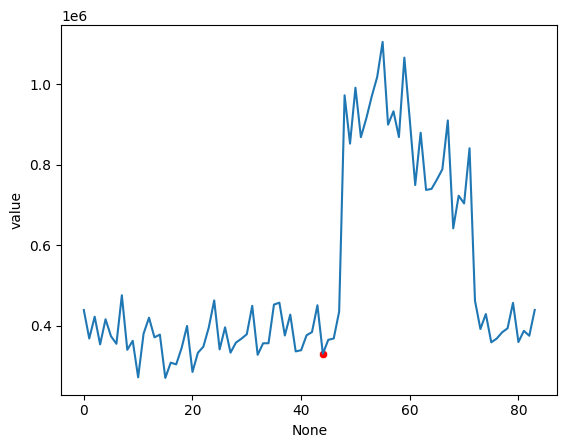

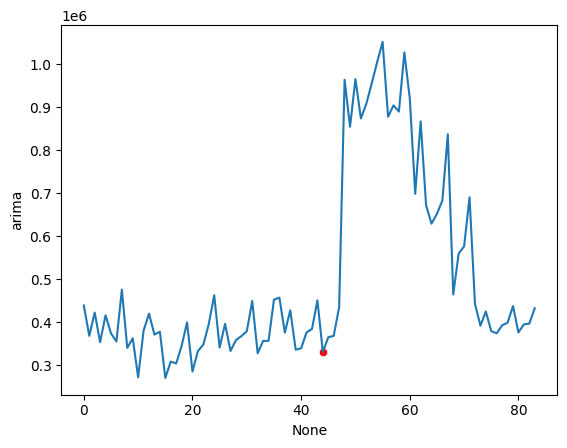

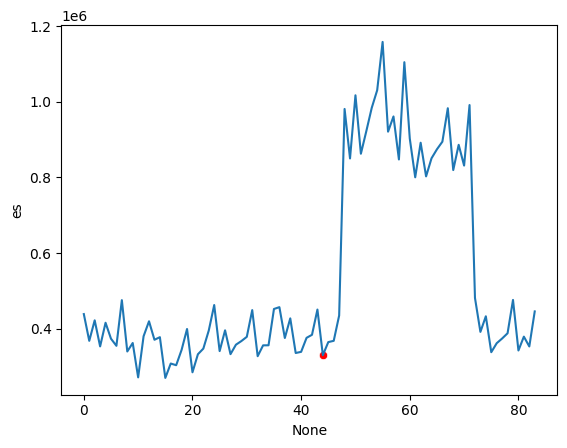

In [22]:
sns.lineplot(x=df_all_model.index, y=df_all_model['value'])
sns.scatterplot(x=[44], y=df_all_model['value'][44], color='red')
plt.show()
sns.lineplot(x=df_all_arima.index, y=df_all_arima['arima'])
sns.scatterplot(x=[44], y=df_all_arima['arima'][44], color='red')
plt.show()
sns.lineplot(x=df_all_es.index, y=df_all_es['es'])
sns.scatterplot(x=[44], y=df_all_es['es'][44], color='red')
plt.show()

In [23]:
df_f_bill['Bill_1'] = df_f_bill['value']

In [24]:
df_f_bill

,Y,M,Project_Name,value,Forecast_date,Project_ID,arima,es,Bill_1
0,2025,01,Красноярск ТЦ / Krasnoyarsk RC,972728.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.644914e+05,9.809651e+05,972728.0
1,2025,02,Красноярск ТЦ / Krasnoyarsk RC,852609.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,8.550228e+05,8.501960e+05,852609.0
2,2025,03,Красноярск ТЦ / Krasnoyarsk RC,991542.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.660165e+05,1.017068e+06,991542.0
3,2025,04,Красноярск ТЦ / Krasnoyarsk RC,868537.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,8.743469e+05,8.627277e+05,868537.0
4,2025,05,Красноярск ТЦ / Krasnoyarsk RC,915437.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.084606e+05,9.224142e+05,915437.0
5,2025,06,Красноярск ТЦ / Krasnoyarsk RC,970156.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.562828e+05,9.840284e+05,970156.0
6,2025,07,Красноярск ТЦ / Krasnoyarsk RC,1018107.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,1.005723e+06,1.030491e+06,1018107.0
7,2025,08,Красноярск ТЦ / Krasnoyarsk RC,1105319.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,1.052545e+06,1.158093e+06,1105319.0
8,2025,09,Красноярск ТЦ / Krasnoyarsk RC,899690.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,8.784252e+05,9.209546e+05,899690.0
9,2025,10,Красноярск ТЦ / Krasnoyarsk RC,932934.0,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,9.046964e+05,9.611706e+05,932934.0


In [25]:
df_f['indx'] = df_f['Project_ID'] + df_f['Y'].astype(str) + df_f['M'].astype(str)
df_f_bill['indx'] = df_f_bill['Project_ID'] + df_f_bill['Y'].astype(str) + df_f_bill['M'].astype(str)

In [26]:
df_f = df_f.set_index('indx').join(df_f_bill[['indx', 'Bill_1']].set_index('indx'))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 0 to 289
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Project_ID    285 non-null    object 
 1   Project_Name  285 non-null    object 
 2   Period        285 non-null    object 
 3   Y             285 non-null    int64  
 4   M             285 non-null    int64  
 5   TO_1          285 non-null    float64
 6   Bill_1        285 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 17.8+ KB


In [28]:
df_f['Y'] = df_f['Y'].astype(int)
df_f['M'] = df_f['M'].astype(int)
df_f = df_f.rename(columns={'value':'TO_1'}).reset_index()

In [29]:
df_f

,indx,Y,M,Project_Name,TO_1,Forecast_date,Project_ID,arima,es,Bill_1
0,7cda2d2a-7c01-11d9-bff3-0007e9405036202501,2025,1,Красноярск ТЦ / Krasnoyarsk RC,2.878917e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.545498e+09,2.212336e+09,972728.0
1,7cda2d2a-7c01-11d9-bff3-0007e9405036202502,2025,2,Красноярск ТЦ / Krasnoyarsk RC,2.641975e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.266283e+09,2.017668e+09,852609.0
2,7cda2d2a-7c01-11d9-bff3-0007e9405036202503,2025,3,Красноярск ТЦ / Krasnoyarsk RC,3.263039e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.989169e+09,2.536909e+09,991542.0
3,7cda2d2a-7c01-11d9-bff3-0007e9405036202504,2025,4,Красноярск ТЦ / Krasnoyarsk RC,2.703634e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.382815e+09,2.024453e+09,868537.0
4,7cda2d2a-7c01-11d9-bff3-0007e9405036202505,2025,5,Красноярск ТЦ / Krasnoyarsk RC,2.873235e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.583565e+09,2.162904e+09,915437.0
5,7cda2d2a-7c01-11d9-bff3-0007e9405036202506,2025,6,Красноярск ТЦ / Krasnoyarsk RC,2.996218e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.733248e+09,2.259188e+09,970156.0
6,7cda2d2a-7c01-11d9-bff3-0007e9405036202507,2025,7,Красноярск ТЦ / Krasnoyarsk RC,3.043133e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.741884e+09,2.344383e+09,1018107.0
7,7cda2d2a-7c01-11d9-bff3-0007e9405036202508,2025,8,Красноярск ТЦ / Krasnoyarsk RC,3.698588e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,4.523717e+09,2.873460e+09,1105319.0
8,7cda2d2a-7c01-11d9-bff3-0007e9405036202509,2025,9,Красноярск ТЦ / Krasnoyarsk RC,3.153622e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.880502e+09,2.426742e+09,899690.0
9,7cda2d2a-7c01-11d9-bff3-0007e9405036202510,2025,10,Красноярск ТЦ / Krasnoyarsk RC,3.267171e+09,20241201,7cda2d2a-7c01-11d9-bff3-0007e9405036,3.971476e+09,2.562867e+09,932934.0


In [30]:
pd.concat([df, df_f])

,Project_ID,Project_Name,Period,Y,M,TO_1,Bill_1,indx,Forecast_date,arima,es
0,06cd6b35-baf1-11e6-878c-6eae8b518839,Петербург Лето ТЦ / Petersburg Leto RC,2021-01-01,2021,1,1.058236e+09,493938.0,NaN,NaN,NaN,NaN
1,06cd6b35-baf1-11e6-878c-6eae8b518839,Петербург Лето ТЦ / Petersburg Leto RC,2021-02-01,2021,2,9.775160e+08,522111.0,NaN,NaN,NaN,NaN
2,06cd6b35-baf1-11e6-878c-6eae8b518839,Петербург Лето ТЦ / Petersburg Leto RC,2021-03-01,2021,3,1.243664e+09,686440.0,NaN,NaN,NaN,NaN
3,06cd6b35-baf1-11e6-878c-6eae8b518839,Петербург Лето ТЦ / Petersburg Leto RC,2021-04-01,2021,4,1.187530e+09,648585.0,NaN,NaN,NaN,NaN
4,06cd6b35-baf1-11e6-878c-6eae8b518839,Петербург Лето ТЦ / Petersburg Leto RC,2021-05-01,2021,5,1.377532e+09,755552.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
31,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,NaN,2025,8,7.876536e+08,456964.0,910dcff5-681f-11e1-9792-001e4f38d301202508,20241201,8.017727e+08,7.735346e+08
32,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,NaN,2025,9,6.143020e+08,359475.0,910dcff5-681f-11e1-9792-001e4f38d301202509,20241201,6.472742e+08,5.813299e+08
33,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,NaN,2025,10,6.637772e+08,387261.0,910dcff5-681f-11e1-9792-001e4f38d301202510,20241201,6.914236e+08,6.361308e+08
34,910dcff5-681f-11e1-9792-001e4f38d301,Новокузнецк ТЦ/ Novokuznetsk RC,NaN,2025,11,6.795383e+08,375142.0,910dcff5-681f-11e1-9792-001e4f38d301202511,20241201,7.098344e+08,6.492421e+08


In [ ]:
pd.concat([df, df_f])[['Project_ID', 'Project_Name', 'Y', 'M', 'TO_1', 'Bill_1']].to_excel('test_to_bill_error.xlsx')

In [31]:
df_f_0 = pd.concat([df, df_f])

In [32]:
df_f_0.Project_ID.unique()

array(['06cd6b35-baf1-11e6-878c-6eae8b518839',
       '0d097e71-5cdf-11db-9eff-505054503030',
       '7281ba51-8569-11e2-bc10-001e4f38d301',
       '7cda2d2a-7c01-11d9-bff3-0007e9405036',
       '910dcff5-681f-11e1-9792-001e4f38d301',
       'd8fb76e9-03e3-11e3-bdd2-001e4f38d486'], dtype=object)

In [33]:
df_f_0.loc[df_f_0['Project_ID'] == 'd8fb76e9-03e3-11e3-bdd2-001e4f38d486'].reset_index(drop=True)

,Project_ID,Project_Name,Period,Y,M,TO_1,Bill_1,indx,Forecast_date,arima,es
0,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-01-01,2021,1,9.054113e+08,460965.0,NaN,NaN,NaN,NaN
1,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-02-01,2021,2,7.993811e+08,407222.0,NaN,NaN,NaN,NaN
2,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-03-01,2021,3,9.622064e+08,463560.0,NaN,NaN,NaN,NaN
3,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-04-01,2021,4,9.170416e+08,428858.0,NaN,NaN,NaN,NaN
4,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-05-01,2021,5,9.898697e+08,471494.0,NaN,NaN,NaN,NaN
5,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-06-01,2021,6,9.299976e+08,444397.0,NaN,NaN,NaN,NaN
6,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-07-01,2021,7,9.344903e+08,460178.0,NaN,NaN,NaN,NaN
7,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-08-01,2021,8,1.227551e+09,566798.0,NaN,NaN,NaN,NaN
8,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-09-01,2021,9,1.057384e+09,437658.0,NaN,NaN,NaN,NaN
9,d8fb76e9-03e3-11e3-bdd2-001e4f38d486,Новосибирск Аура ТЦ / Novosibirsk Aura RC,2021-10-01,2021,10,1.066716e+09,433567.0,NaN,NaN,NaN,NaN


In [34]:
df_spb = df_f_0.loc[df_f_0['Project_ID'] == '06cd6b35-baf1-11e6-878c-6eae8b518839'].reset_index(drop=True)
df_ufa = df_f_0.loc[df_f_0['Project_ID'] == '0d097e71-5cdf-11db-9eff-505054503030'].reset_index(drop=True)
df_perm = df_f_0.loc[df_f_0['Project_ID'] == '7281ba51-8569-11e2-bc10-001e4f38d301'].reset_index(drop=True)
df_krs = df_f_0.loc[df_f_0['Project_ID'] == '7cda2d2a-7c01-11d9-bff3-0007e9405036'].reset_index(drop=True)
df_nvk = df_f_0.loc[df_f_0['Project_ID'] == '910dcff5-681f-11e1-9792-001e4f38d301'].reset_index(drop=True)
df_nvs = df_f_0.loc[df_f_0['Project_ID'] == 'd8fb76e9-03e3-11e3-bdd2-001e4f38d486'].reset_index(drop=True)

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

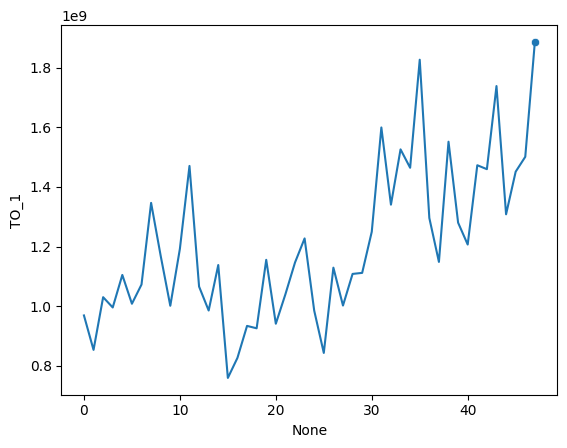

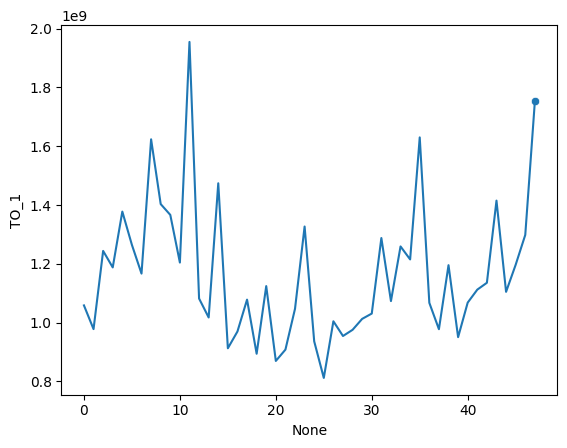

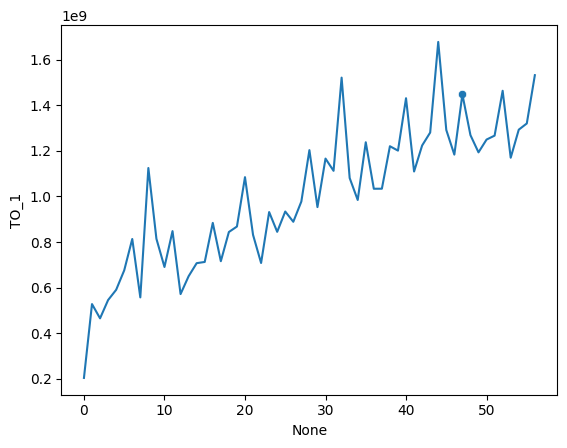

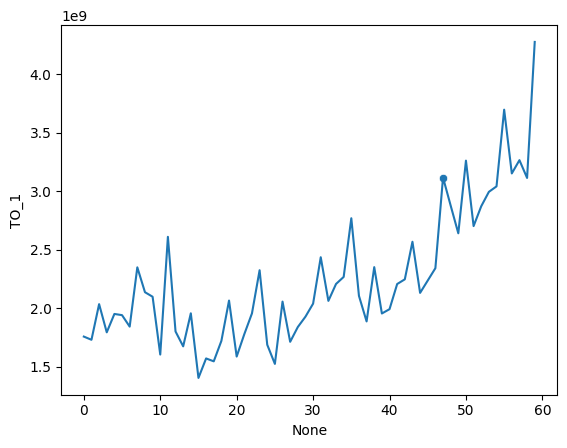

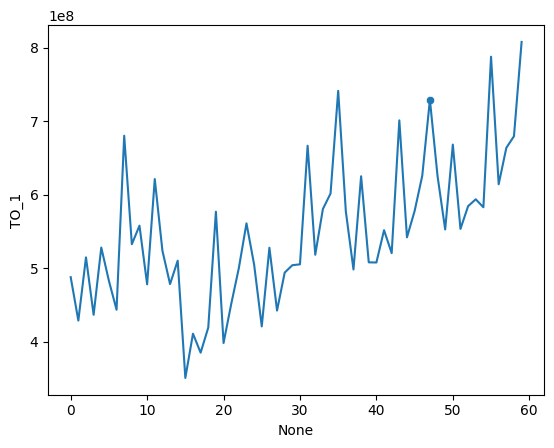

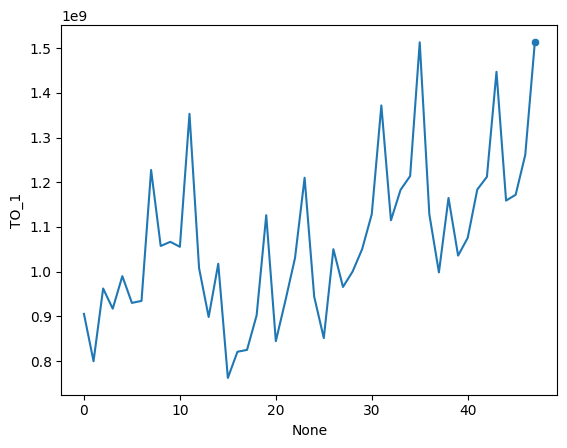

In [40]:
sns.lineplot(y=df_ufa['TO_1'], x=df_ufa.index)
sns.scatterplot(y=df_ufa['TO_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_spb['TO_1'], x=df_spb.index)
sns.scatterplot(y=df_spb['TO_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_perm['TO_1'], x=df_perm.index)
sns.scatterplot(y=df_perm['TO_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_krs['TO_1'], x=df_krs.index)
sns.scatterplot(y=df_krs['TO_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_nvk['TO_1'], x=df_nvk.index)
sns.scatterplot(y=df_nvk['TO_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_nvs['TO_1'], x=df_nvs.index)
sns.scatterplot(y=df_nvs['TO_1'][47], x=[47])
plt.show()

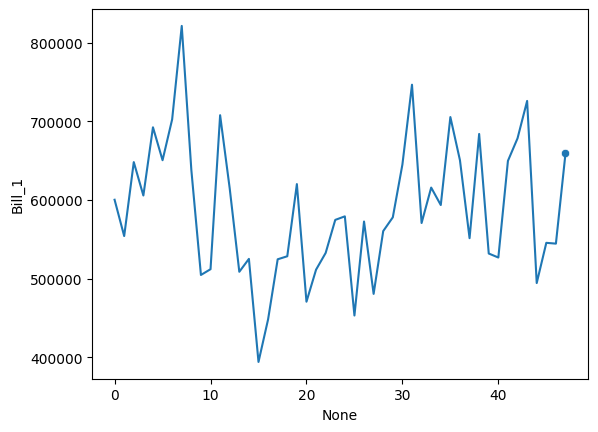

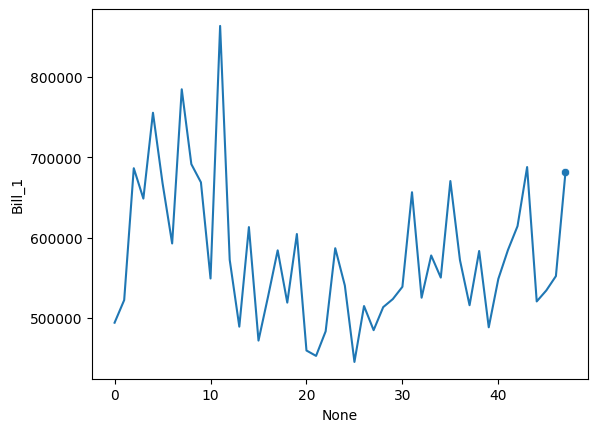

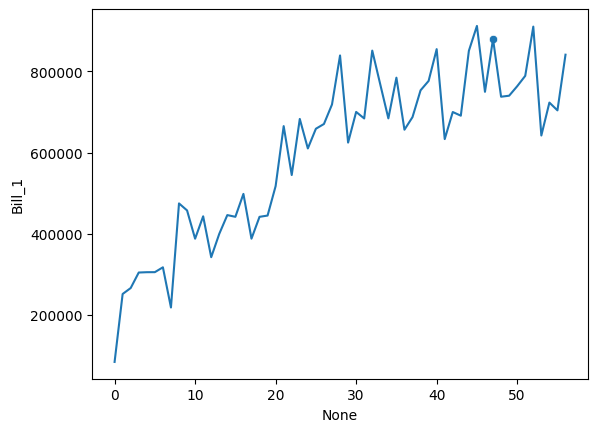

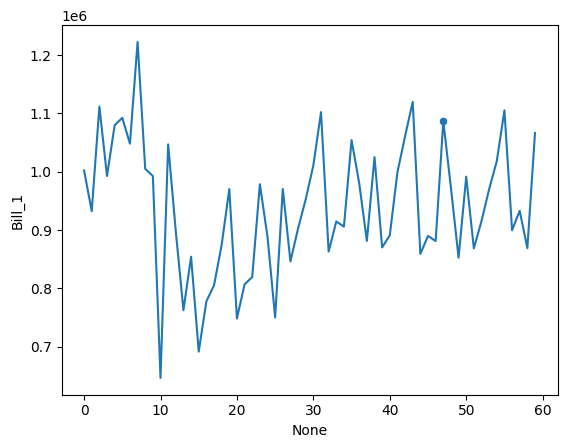

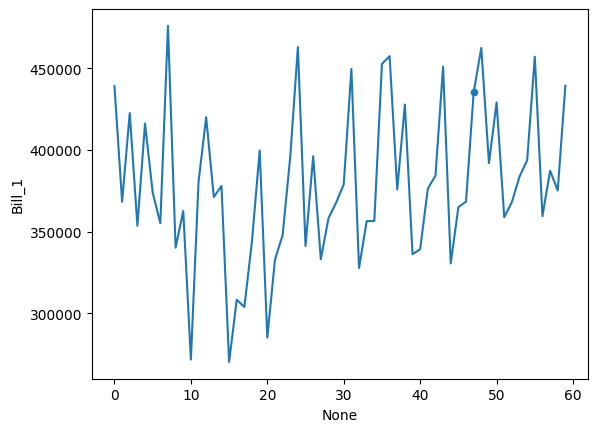

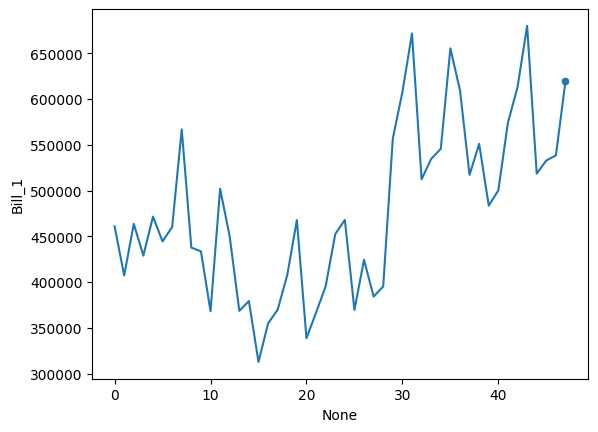

In [41]:
sns.lineplot(y=df_ufa['Bill_1'], x=df_ufa.index)
sns.scatterplot(y=df_ufa['Bill_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_spb['Bill_1'], x=df_spb.index)
sns.scatterplot(y=df_spb['Bill_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_perm['Bill_1'], x=df_perm.index)
sns.scatterplot(y=df_perm['Bill_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_krs['Bill_1'], x=df_krs.index)
sns.scatterplot(y=df_krs['Bill_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_nvk['Bill_1'], x=df_nvk.index)
sns.scatterplot(y=df_nvk['Bill_1'][47], x=[47])
plt.show()
sns.lineplot(y=df_nvs['Bill_1'], x=df_nvs.index)
sns.scatterplot(y=df_nvs['Bill_1'][47], x=[47])
plt.show()